# Kuzushiji Classification with Support Vector Machines

In this notebook we are going to explore the use of Support Vector Machines (SVM) for image classification. We will use a variant of the famous MNIST dataset (the original is a dataset of handwritten digits). The version we are going to use is called Kuzushiji-MNIST or K-MNIST for short (https://github.com/rois-codh/kmnist) and is a dataset of traditional japanese handwritten kana.

The dataset labels are the following:

| Label | Hiragana Character | Romanji (Pronunciation) |
| :-: | :-: | :-: |
|   0   | お | o |
| 1 | き | ki |
| 2 | す | su |
| 3 | つ | tsu |
| 4 | な | na |
| 5 | は | ha |
| 6 | ま | ma |
| 7 | や | ya |
| 8 | れ | re |
| 9 | を | wo |

## TO DO: Insert your surname, name and ID number

Student surname: Ninni

Student name: Daniele
    
ID: 2044721

In [1]:
# load the required packages
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
import sklearn.metrics as skm

In [2]:
# helper function to load Kuzushiji-MNIST dataset
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np
    labels_path = os.path.join(path, 'K%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, 'K%s-images-idx3-ubyte.gz' % kind)
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)
    return images, labels

In [3]:
# fix your ID ("numero di matricola") and the seed for random generator (as usual you can try different seeds)
ID = 2044721   # place a random seed
np.random.seed(ID)

In [4]:
# load the K-MNIST dataset from the 'data' folder and let's normalize the features so that each value is in [0,1] 
X, y = load_mnist('data', kind='train')

# rescale the data
X, y = X/255., y   # original pixel values are between 0 and 255

print('X.shape =', X.shape)
print('y.shape =', y.shape)

X.shape = (60000, 784)
y.shape = (60000,)


Now split into training and test. Make sure that each label is present at least 10 times in training. If it is not, then keep adding permutations to the initial data until this happens.

In [5]:
# random permute the data and split into training and test taking the first 1000 data samples as training and 4000 samples as test
permutation = np.random.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]

m_training = 1000
m_test = 4000

X_train, X_test = X[:m_training], X[m_training:m_training+m_test:]
y_train, y_test = y[:m_training], y[m_training:m_training+m_test:]

labels, freqs = np.unique(y_train, return_counts=True)

# making sure that each label is present at least 10 times in 'y_train'
while np.any(freqs<10) == True:
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    X_train, X_test = X[:m_training], X[m_training:m_training+m_test:]
    y_train, y_test = y[:m_training], y[m_training:m_training+m_test:]
    labels, freqs = np.unique(y_train, return_counts=True)

print("Labels in the training dataset:", labels)
print("Frequencies in the training dataset:", freqs)

Labels in the training dataset: [0 1 2 3 4 5 6 7 8 9]
Frequencies in the training dataset: [ 93 105 113  96  94 104 108 100  90  97]


In [6]:
# function for plotting a image and printing the corresponding label
def plot_input(X_matrix, labels, index):
    print("INPUT:")
    plt.imshow(
        X_matrix[index].reshape(28,28),
        cmap          = plt.cm.gray_r,
        interpolation = "nearest"
    )
    plt.show()
    print("LABEL: %i" % labels[index])
    return

INPUT:


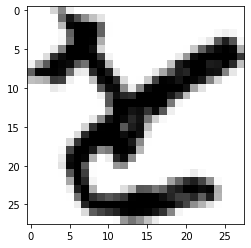

LABEL: 9



INPUT:


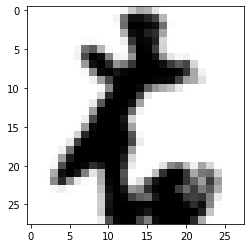

LABEL: 5



INPUT:


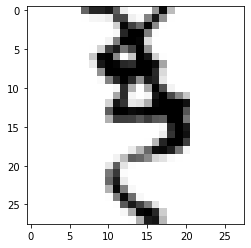

LABEL: 1



INPUT:


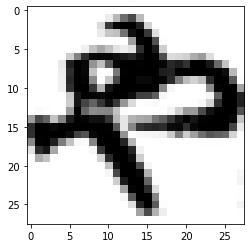

LABEL: 7


In [7]:
# let's try the plotting function
plot_input(X_train,y_train,5)
print("\n\n")
plot_input(X_test,y_test,50)
print("\n\n")
plot_input(X_test,y_test,500)
print("\n\n")
plot_input(X_test,y_test,700)

## TO DO 1

Use a SVM classifier with cross validation to pick a model. Use a 4-fold cross-validation. Let's start with a Linear kernel:

In [8]:
# import SVC
from sklearn.svm import SVC
# import for Cross-Validation
from sklearn.model_selection import GridSearchCV

K = 4   # number of folds

# parameters for linear SVM
parameters = {'C':[0.01, 0.1, 1, 10]}

# train linear SVM
lin_svc = SVC(kernel='linear')
lin_clf = GridSearchCV(lin_svc, parameters, cv=K)
lin_clf.fit(X_train, y_train)

print('RESULTS FOR LINEAR KERNEL')
print("Best parameters set found:", lin_clf.best_params_)
print("Score with best parameters:", lin_clf.best_score_)
print("All scores on the grid:")
import pandas as pd
lin_results = pd.DataFrame(lin_clf.cv_results_)
lin_results

RESULTS FOR LINEAR KERNEL
Best parameters set found: {'C': 0.01}
Score with best parameters: 0.766
All scores on the grid:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.092091,0.012031,0.037096,0.013021,0.01,{'C': 0.01},0.760,0.732,0.816,0.756,0.766,0.030790,1
1,0.082770,0.006457,0.030852,0.001580,0.1,{'C': 0.1},0.784,0.704,0.788,0.780,0.764,0.034756,2
2,0.090473,0.003417,0.028898,0.004337,1,{'C': 1},0.784,0.696,0.780,0.788,0.762,0.038210,3
3,0.085389,0.004281,0.023763,0.005598,10,{'C': 10},0.784,0.696,0.780,0.788,0.762,0.038210,3


## TO DO 2

Pick a model for the Polynomial kernel of degree 2:

In [9]:
# parameters for poly of degree 2 kernel
parameters = {'C':[0.01, 0.1, 1], 'gamma':[0.01,0.1,1]}

# run SVM with poly of degree 2 kernel
degree = 2   # degree of the polynomial kernel function
deg2_svc = SVC(kernel='poly', degree=degree)
deg2_clf = GridSearchCV(deg2_svc, parameters, cv=K)
deg2_clf.fit(X_train, y_train)

print('RESULTS FOR POLYNOMIAL KERNEL OF DEGREE', degree)
print("Best parameters set found:", deg2_clf.best_params_)
print("Score with best parameters:", deg2_clf.best_score_)
print("All scores on the grid:")
deg2_results = pd.DataFrame(deg2_clf.cv_results_)
deg2_results

RESULTS FOR POLYNOMIAL KERNEL OF DEGREE 2
Best parameters set found: {'C': 0.01, 'gamma': 0.1}
Score with best parameters: 0.792
All scores on the grid:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.158798,0.004329,0.063793,0.002073,0.01,0.01,"{'C': 0.01, 'gamma': 0.01}",0.112,0.112,0.112,0.116,0.113,0.001732,9
1,0.122504,0.013089,0.056005,0.009785,0.01,0.1,"{'C': 0.01, 'gamma': 0.1}",0.808,0.760,0.812,0.788,0.792,0.020591,1
2,0.121045,0.007124,0.037613,0.007496,0.01,1,"{'C': 0.01, 'gamma': 1}",0.800,0.752,0.804,0.808,0.791,0.022694,3
3,0.157614,0.013290,0.067513,0.012413,0.1,0.01,"{'C': 0.1, 'gamma': 0.01}",0.516,0.504,0.508,0.576,0.526,0.029189,8
4,0.109883,0.003622,0.028126,0.004130,0.1,0.1,"{'C': 0.1, 'gamma': 0.1}",0.792,0.748,0.796,0.812,0.787,0.023728,7
5,0.110783,0.005493,0.024084,0.005580,0.1,1,"{'C': 0.1, 'gamma': 1}",0.800,0.752,0.804,0.808,0.791,0.022694,3
6,0.122161,0.013495,0.041985,0.006882,1,0.01,"{'C': 1, 'gamma': 0.01}",0.808,0.760,0.812,0.788,0.792,0.020591,1
7,0.108953,0.009441,0.029721,0.008821,1,0.1,"{'C': 1, 'gamma': 0.1}",0.800,0.752,0.804,0.808,0.791,0.022694,3
8,0.127092,0.010205,0.032524,0.009524,1,1,"{'C': 1, 'gamma': 1}",0.800,0.752,0.804,0.808,0.791,0.022694,3


## TO DO 3

Now let's try a higher degree for the Polynomial kernel (e.g., 3rd degree):

In [10]:
# parameters for poly of higher degree kernel
parameters = {'C':[0.01, 0.1, 1], 'gamma':[0.01,0.1,1]}

# run SVM with poly of higher degree kernel
degree = 3   # degree of the polynomial kernel function
deg3_svc = SVC(kernel='poly', degree=degree)
deg3_clf = GridSearchCV(deg3_svc, parameters, cv=K)
deg3_clf.fit(X_train, y_train)

print('RESULTS FOR POLYNOMIAL KERNEL OF DEGREE', degree)
print("Best parameters set found:", deg3_clf.best_params_)
print("Score with best parameters:", deg3_clf.best_score_)
print("All scores on the grid:")
deg3_results = pd.DataFrame(deg3_clf.cv_results_)
deg3_results

RESULTS FOR POLYNOMIAL KERNEL OF DEGREE 3
Best parameters set found: {'C': 0.01, 'gamma': 0.1}
Score with best parameters: 0.746
All scores on the grid:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.177721,0.009771,0.073000,0.014412,0.01,0.01,"{'C': 0.01, 'gamma': 0.01}",0.112,0.112,0.112,0.116,0.113,0.001732,9
1,0.132986,0.008757,0.025993,0.004066,0.01,0.1,"{'C': 0.01, 'gamma': 0.1}",0.740,0.704,0.764,0.776,0.746,0.027495,1
2,0.141464,0.010905,0.030121,0.008933,0.01,1,"{'C': 0.01, 'gamma': 1}",0.724,0.700,0.760,0.780,0.741,0.031032,2
3,0.164255,0.003898,0.061994,0.003455,0.1,0.01,"{'C': 0.1, 'gamma': 0.01}",0.468,0.436,0.408,0.468,0.445,0.025040,8
4,0.128041,0.000172,0.025924,0.006776,0.1,0.1,"{'C': 0.1, 'gamma': 0.1}",0.724,0.700,0.760,0.780,0.741,0.031032,2
5,0.129014,0.006980,0.015655,0.000025,0.1,1,"{'C': 0.1, 'gamma': 1}",0.724,0.700,0.760,0.780,0.741,0.031032,2
6,0.117272,0.013459,0.031270,0.000013,1,0.01,"{'C': 1, 'gamma': 0.01}",0.752,0.692,0.752,0.756,0.738,0.026608,7
7,0.130103,0.008858,0.027527,0.006869,1,0.1,"{'C': 1, 'gamma': 0.1}",0.724,0.700,0.760,0.780,0.741,0.031032,2
8,0.133799,0.007515,0.028806,0.002975,1,1,"{'C': 1, 'gamma': 1}",0.724,0.700,0.760,0.780,0.741,0.031032,2


## TO DO 4

Pick a model for the Radial Basis Function kernel:

In [11]:
# parameters for rbf SVM
parameters = {'C':[0.1, 1, 10, 100], 'gamma':[0.001, 0.01, 0.1,1]}

# run SVM with rbf kernel
rbf_svc = SVC(kernel='rbf')
rbf_clf = GridSearchCV(rbf_svc, parameters, cv=K)
rbf_clf.fit(X_train, y_train)

print('RESULTS FOR RBF KERNEL')
print("Best parameters set found:", rbf_clf.best_params_)
print("Score with best parameters:", rbf_clf.best_score_)
print("All scores on the grid:")
rbf_results = pd.DataFrame(rbf_clf.cv_results_)
rbf_results

RESULTS FOR RBF KERNEL
Best parameters set found: {'C': 10, 'gamma': 0.01}
Score with best parameters: 0.822
All scores on the grid:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.192940,0.033329,0.119880,0.017965,0.1,0.001,"{'C': 0.1, 'gamma': 0.001}",0.112,0.112,0.112,0.116,0.113,0.001732,11
1,0.171856,0.000008,0.109566,0.011144,0.1,0.01,"{'C': 0.1, 'gamma': 0.01}",0.324,0.364,0.356,0.412,0.364,0.031496,7
2,0.235342,0.032935,0.176855,0.019860,0.1,0.1,"{'C': 0.1, 'gamma': 0.1}",0.112,0.112,0.112,0.116,0.113,0.001732,11
3,0.200286,0.017635,0.132564,0.027588,0.1,1,"{'C': 0.1, 'gamma': 1}",0.112,0.112,0.112,0.116,0.113,0.001732,11
4,0.133392,0.007649,0.094626,0.000482,1,0.001,"{'C': 1, 'gamma': 0.001}",0.656,0.656,0.704,0.716,0.683,0.027331,6
5,0.156522,0.018705,0.086692,0.007546,1,0.01,"{'C': 1, 'gamma': 0.01}",0.840,0.756,0.836,0.800,0.808,0.033823,3
6,0.180575,0.007751,0.100317,0.006614,1,0.1,"{'C': 1, 'gamma': 0.1}",0.164,0.180,0.188,0.188,0.180,0.009798,10
7,0.178139,0.009572,0.114357,0.006448,1,1,"{'C': 1, 'gamma': 1}",0.112,0.112,0.112,0.116,0.113,0.001732,11
8,0.094245,0.003479,0.065652,0.007732,10,0.001,"{'C': 10, 'gamma': 0.001}",0.788,0.728,0.832,0.776,0.781,0.037027,4
9,0.161843,0.008320,0.098097,0.012876,10,0.01,"{'C': 10, 'gamma': 0.01}",0.840,0.768,0.840,0.840,0.822,0.031177,1


## QUESTION 1

What do you observe when using linear, polynomial and RBF kernels on this dataset?

## ANSWER 1

Results:

| Kernel | Best 'C' | Best 'gamma' | Best score |
| :-: | :-: | :-: | :-: |
| Linear | 0.01 | - | 0.766 |
| Polynomial of degree 2 | 0.01 | 0.1 | 0.792 |
| Polynomial of degree 3 | 0.01 | 0.1 | 0.746 |
| RBF | 10 | 0.01 | 0.822 |

Observations:

- the polynomial kernel of degree 2 scores better than both the linear kernel and the polynomial kernel of degree 3;
- the linear kernel and the polynomial kernels found the same best value of the parameter 'C';
- the polynomial kernels found the same best value of the parameter 'gamma';
- the polynomial kernel of degree 3 is the one that achieves the lowest accuracy (about 75%);
- the RBF kernel is the one that achieves the best accuracy (about 82%);
- all the kernels achieve an accuracy of at least 74%;
- the training time increases with the complexity of the kernel function;
- the accuracy does not necessarily increase with the complexity of the kernel function (e.g. the accuracy of the polynomial kernel of degree 3 is lower not only than that of the polynomial kernel of degree 2, but also than that of the linear kernel!).

## TO DO 5

Report here the best SVM kernel and parameters:

In [12]:
# get training and test error for the best SVM model from CV
best_SVM = rbf_clf.best_estimator_
best_SVM.fit(X_train, y_train)
training_error = 1-best_SVM.score(X_train, y_train)
test_error = 1-best_SVM.score(X_test, y_test)

print ("Best SVM training error:", training_error)
print ("Best SVM test error:", test_error)

Best SVM training error: 0.0
Best SVM test error: 0.14949999999999997


## TO DO 6

Analyze how the gamma parameter (inversely proportional to the standard deviation of the Gaussian Kernel) impacts the performances of the classifier:

In [13]:
# test with different values of gamma
gamma_values = np.logspace(-5,2,8)   # set gamma values
print("Values of the 'gamma' parameter:", gamma_values)

Values of the 'gamma' parameter: [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]


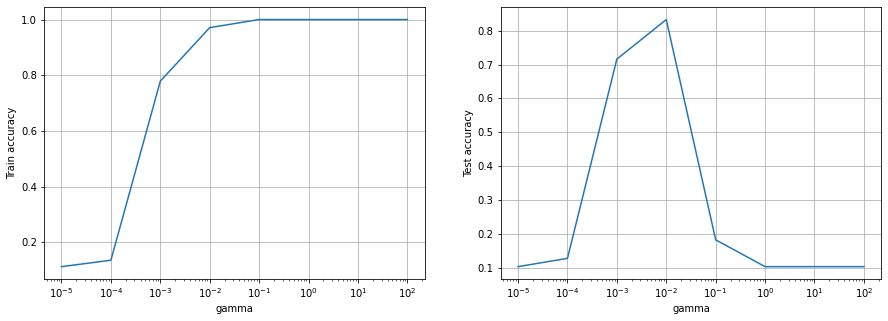

In [14]:
# try the SVM with the previously set values of gamma, use rbf kernel and C=1
train_acc_list, test_acc_list = [], []

# training the SVM multiple times with the different values of gamma
for i in gamma_values:
    parameters = {'C':[1], 'gamma':[i]}
    rbf_clf = GridSearchCV(rbf_svc, parameters, cv=K)
    rbf_clf.fit(X_train, y_train)

    # placing the train and test accuracy for each test in the train and test accuracy lists
    train_acc = rbf_clf.score(X_train, y_train)
    test_acc = rbf_clf.score(X_test, y_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

# plot
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(gamma_values, train_acc_list)
ax[0].set_xscale('log')
ax[0].set_xlabel('gamma')
ax[0].set_ylabel('Train accuracy')
ax[0].grid(True)

ax[1].plot(gamma_values, test_acc_list)
ax[1].set_xscale('log')
ax[1].set_xlabel('gamma')
ax[1].set_ylabel('Test accuracy')
ax[1].grid(True)

plt.show()

## QUESTION 2

How do the train and test error change when changing gamma? Which is the best value of gamma? 
Connect your answers to the discussion about the overfitting issue.

## ANSWER 2

Observations:

- the training error decreases with the increase of $gamma$ until it becomes equal to $0$ for $gamma > 10^{-1}$;
- the test error decreases with the increase of $gamma$ until it reaches the absolute minimum corresponding to $gamma = 10^{-2}$, then it begins to increase with the increase of $gamma$ until it becomes equal to $1$ for $gamma > 1$.

The best value of $gamma$ should be the one that leads to the best trade-off between precisely fitting the training set (i.e. minimizing the training error, with the risk of overfitting) and finding a less accurate but more general solution (i.e. minimizing the test error). Therefore, given the trends of the training error and of the test error as a function of $gamma$, it is reasonable to assume that the best value of $gamma$ is 

$gamma_{best} = 10^{-2}$

Note that:

- a lower value of $gamma$ would lead to an increase in both the training error and the test error;
- it is true that a larger value of $gamma$ would lead to a further decrease of the training error, but at the same time it would increase the risk of overfitting the model! (i.e. it would lead to a drastic increase in the test error).

## More data

Now let's do the same but using more data points for training.

Choose a new number of data points:

In [15]:
X = X[permutation]
y = y[permutation]

m_training = 2000   # TODO number of data points, adjust depending on the capabilities of your PC

X_train, X_test = X[:m_training], X[m_training:]
y_train, y_test = y[:m_training], y[m_training:]

labels, freqs = np.unique(y_train, return_counts=True)

# making sure that each label is present at least 20 times in 'y_train'
while np.any(freqs<20) == True:
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    X_train, X_test = X[:m_training], X[m_training:]
    y_train, y_test = y[:m_training], y[m_training:]
    labels, freqs = np.unique(y_train, return_counts=True)

print("Labels in the training dataset:", labels)
print("Frequencies in the training dataset:", freqs)

Labels in the training dataset: [0 1 2 3 4 5 6 7 8 9]
Frequencies in the training dataset: [214 193 215 182 214 172 201 198 196 215]


## TO DO 7

Let's try to use SVM with parameters obtained from the best model for $m_{training} = 2000$. Since it may take a long time to run, you can decide to just let it run for some time and stop it if it does not complete. If you decide to do this, report it in the cell below:

In [16]:
# get training and test error for the best SVM model from CV
best_SVM.fit(X_train, y_train)
training_error = 1-best_SVM.score(X_train, y_train)
test_error = 1-best_SVM.score(X_test, y_test)

print("Best SVM training error:", training_error)
print("Best SVM test error:", test_error)

Best SVM training error: 0.0
Best SVM test error: 0.1144310344827586


Just for comparison, let's also use logistic regression:

## TO DO 8 Try first without regularization (use a very large C)

In [17]:
from sklearn import linear_model

logreg = linear_model.LogisticRegression(C=1e5, max_iter=1000)   # a large C disables regularization
logreg.fit(X_train, y_train)
training_error = 1-logreg.score(X_train, y_train)
test_error = 1-logreg.score(X_test, y_test)

print("Best logistic regression training error:", training_error)
print("Best logistic regression test error:", test_error)

Best logistic regression training error: 0.0
Best logistic regression test error: 0.2736206896551724


## TO DO 9 Try with regularization (use C=1)

In [18]:
logreg_regularized = linear_model.LogisticRegression(C=1, max_iter=1000)
logreg_regularized.fit(X_train, y_train)
training_error = 1-logreg_regularized.score(X_train, y_train)
test_error = 1-logreg_regularized.score(X_test, y_test)

print("Best regularized logistic regression training error:", training_error)
print("Best regularized logistic regression test error:", test_error)

Best regularized logistic regression training error: 0.0014999999999999458
Best regularized logistic regression test error: 0.24775862068965515


## QUESTION 3

Compare and discuss:
- the results from SVM with $m = 1000$ and with $m = 2000$ training data points. If you stopped the SVM, include such aspect in your comparison
- the results of SVM and of Logistic Regression

## ANSWER 3

Results (the SVM has not been stopped):

| Model | Training error | Test error | Training time $(s)$ |
| :-: | :-: | :-: | :-: |
| SVM $(m = 1000)$ | 0 | 0.1495 | 2.9 |
| SVM $(m = 2000)$ | 0 | 0.1144 | 61.5 |
| Logistic regression | 0 | 0.2736 | 0.9 |
| Logistic regression (regularized) | 0.0015 | 0.2478 | 1.8 |

Observations:

- training the SVM with $m = 2000$ instead of $m = 1000$ led to a decrease of the test error of about 3.5%; however, the training time became about 20 times longer! (as expected, as $m$ increases both test accuracy and training time increase)
- the logistic regression (both in the regularized and non-regularized case) led to worse results (in terms of both training error and test error) than those obtained with the SVM, without even leading to significant improvements in terms of training time!

## TO DO 10

Plot a character that is misclassified by logistic regression and correctly classified by SVM:

Example of a character that is misclassified by logistic regression and correctly classified by SVM:
INPUT:


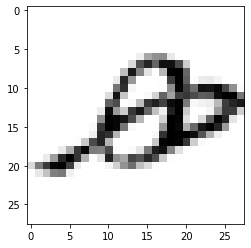

LABEL: 7
Label predicted by logistic regression: 9
Label predicted by SVM: 7


In [19]:
LR_prediction = logreg_regularized.predict(X_test)
SVM_prediction = best_SVM.predict(X_test)
for i in range(m_test):
    if LR_prediction[i] != y_test[i] and SVM_prediction[i] == y_test[i]:
        break

print("Example of a character that is misclassified by logistic regression and correctly classified by SVM:")
plot_input(X_test,y_test,i)
print("Label predicted by logistic regression:", LR_prediction[i])
print("Label predicted by SVM:", SVM_prediction[i])

## TO DO 11

Plot the confusion matrix for the SVM classifier and for the logistic regression.
The confusion matrix has one column for each predicted label and one row for each true label. 
It shows for each class in the corresponding row how many samples belonging to that class gets each possible output label.
Notice that the diagonal contains the correctly classified samples, while the other cells correspond to errors.
You can obtain it with the sklearn.metrics.confusion_matrix function (see the documentation).
Try also to normalize the confusion matrix by the number of samples in each class in order to measure the accuracy on each single class.

Labels in the test dataset: [0 1 2 3 4 5 6 7 8 9]
Frequencies in the test dataset: [5786 5807 5785 5818 5786 5828 5799 5802 5804 5785]

Confusion matrix SVM:


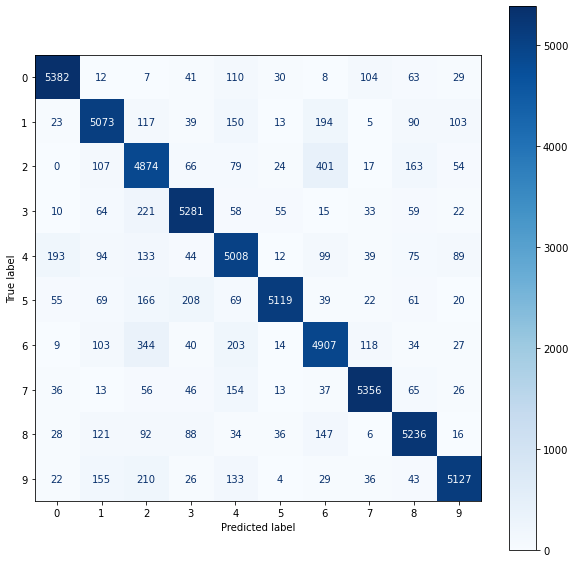


Confusion matrix SVM (normalized):


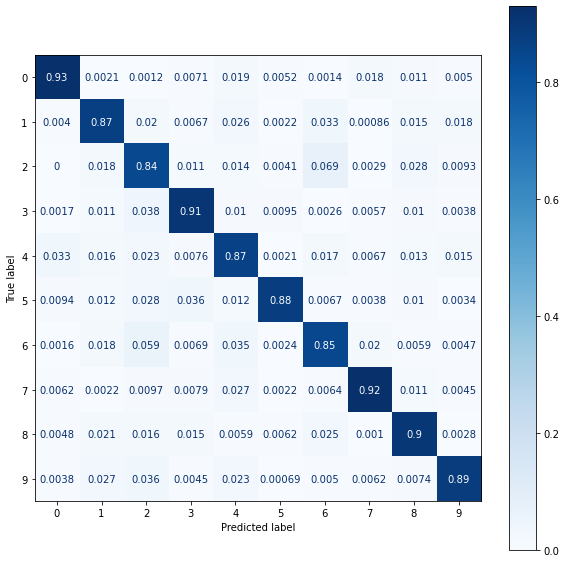


Confusion matrix LR:


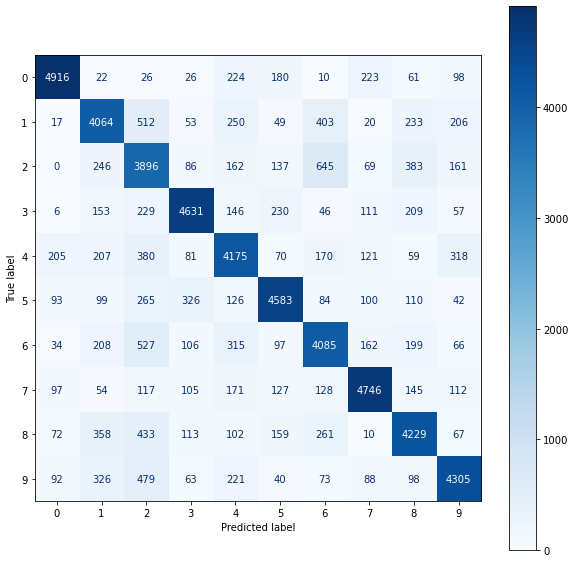


Confusion matrix LR (normalized):


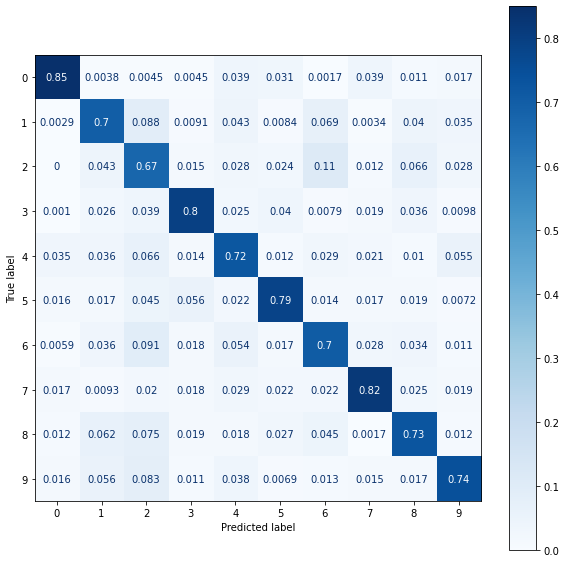

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

np.set_printoptions(precision=2, suppress=True)   # for better aligned printing of confusion matrix use floatmode='fixed'

u, counts = np.unique(y_test, return_counts=True)
print("Labels in the test dataset:", u)
print("Frequencies in the test dataset:", counts)

def print_cm(cm):
    fig, ax = plt.subplots(figsize=(10,10))
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.show()

confusion_SVM = confusion_matrix(y_test, SVM_prediction)
print("\nConfusion matrix SVM:")
print_cm(confusion_SVM)
print("\nConfusion matrix SVM (normalized):")
print_cm(confusion_SVM/counts[:,None])

confusion_LR = confusion_matrix(y_test, LR_prediction)
print("\nConfusion matrix LR:")
print_cm(confusion_LR)
print("\nConfusion matrix LR (normalized):")
print_cm(confusion_LR/counts[:,None])

## QUESTION 4

Have a look at the confusion matrices and comment on the obtained accuracies. Why some classes have lower accuracies and others an higher one? Make some guesses on the possible causes.

## ANSWER 4

It makes sense to assume that some classes have lower accuracies than those of other classes because:

- the worst classified characters are particularly similar to others and therefore it is more challenging to recognise them;
- the better classified characters have some unique features that make them easier to recognise.

Let's analyze in detail the results in terms of accuracy:

| Model | Worst accuracy | Best accuracy |
| :-: | :-: | :-: |
| SVM $(m = 1000)$ | 0.84 (class 2) | 0.93 (class 0) |
| Logistic regression (regularized) | 0.67 (class 2) | 0.85 (class 0) |

Observations:

- SVM: classes have fairly similar accuracies (less than 10% difference between the worst and the best);
- LR: the differences between the classes accuracies are more evident (almost 20% difference between the worst and the best).

In general:

- the character corresponding to class 0 is the best classified;
- the character corresponding to class 2 is the worst classified and is mainly confused with the character corresponding to class 6.

Let's see an example of a character corresponding to class 2 that is (mis)classified by both the SVM and the LR as a character corresponding to class 6 and vice versa:

Example of a character corresponding to class 2 that is (mis)classified by both the SVM and the LR as a character corresponding to class 6:
INPUT:


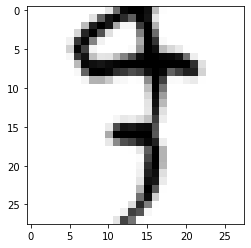

LABEL: 2
Label predicted by logistic regression: 6
Label predicted by SVM: 6


Example of a character corresponding to class 6 that is (mis)classified by both the SVM and the LR as a character corresponding to class 2:
INPUT:


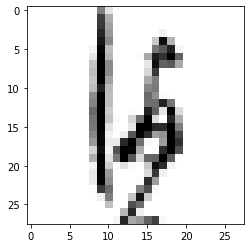

LABEL: 6
Label predicted by logistic regression: 2
Label predicted by SVM: 2


In [21]:

# searching for a character corresponding to class 2 that is (mis)classified by both the SVM and the LR as a character corresponding to class 6
for i in range(m_test):
    if y_test[i] == 2 and LR_prediction[i] == 6 and SVM_prediction[i] == 6:
        break

print("Example of a character corresponding to class 2 that is (mis)classified by both the SVM and the LR as a character corresponding to class 6:")
plot_input(X_test,y_test,i)
print("Label predicted by logistic regression:", LR_prediction[i])
print("Label predicted by SVM:", SVM_prediction[i])

# searching for a character corresponding to class 6 that is (mis)classified by both the SVM and the LR as a character corresponding to class 2
for i in range(m_test):
    if y_test[i] == 6 and LR_prediction[i] == 2 and SVM_prediction[i] == 2:
        break

print("\n\nExample of a character corresponding to class 6 that is (mis)classified by both the SVM and the LR as a character corresponding to class 2:")
plot_input(X_test,y_test,i)
print("Label predicted by logistic regression:", LR_prediction[i])
print("Label predicted by SVM:", SVM_prediction[i])